In [1]:
# !pip install -r requirements.txt
# !pip install fbprophet
# !pip install xlrd
# !pip install openpyxl


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
from darts import TimeSeries
from darts.models import (
    FFT,
    ExponentialSmoothing,
    Theta
)
from darts.metrics import mape
from darts.utils.missing_values import fill_missing_values
from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor

plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

[2021-07-10 14:57:56,508] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-07-10 14:57:57,131] WARNING | darts.models | Support Torch based models not available. To enable it, install u8darts[torch] or u8darts[all].


In [3]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [4]:
data = pd.read_csv('data/district/Actuals.csv')
data = data.loc[data.Time<'2020-11-06'] #getting rid of the overlap
data.Time = data.Time.astype('datetime64[ns]')
data.set_index('Time', inplace=True)

data

# data_Interim = pd.read_csv('Interim_dataset/Actuals_Interim.csv')
# data_Interim['Time'] = data_Interim['Time'].astype('datetime64[ns]')
# data_Interim.set_index('Time', inplace=True)

# data_Forecast_Interim = pd.read_csv('Interim_dataset/Forecasts_Interim.csv')[['Temperature (C) ','Pressure_kpa',
#                        'Cloud Cover (%)','Wind Direction (deg)',
#                       'Wind Speed (kmh)','Time']].dropna()

# data_Forecast_Interim['Time'] = data_Forecast_Interim['Time'].astype('datetime64[ns]')
# data_Forecast_Interim.set_index('Time', inplace=True)

# data_Forecast_Interim['Load (kW)'] = data_Interim['Load (kW)']
# data_Forecast_Interim.reset_index(inplace=True)

,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Wind Direction (deg),Wind Speed (kmh)
Time,,,,,,,
2017-03-18 00:00:00,1.031472e+06,1012.48000,2.125,79.333333,16.764386,285.250,6.25375
2017-03-18 01:00:00,1.007206e+06,1011.61875,0.000,82.166667,15.729386,285.000,9.20500
2017-03-18 02:00:00,9.861084e+05,1010.72000,2.125,81.666667,15.816886,316.000,11.28375
2017-03-18 03:00:00,9.707610e+05,1011.37625,17.125,82.250000,15.919386,327.000,7.16875
2017-03-18 04:00:00,9.622584e+05,1011.50000,18.625,82.333333,15.769386,282.250,0.78000
...,...,...,...,...,...,...,...
2020-11-05 19:00:00,1.141299e+06,1010.35000,53.375,69.333333,18.319386,342.000,10.18625
2020-11-05 20:00:00,1.112590e+06,1011.10000,36.875,69.333333,17.819386,221.500,8.77000
2020-11-05 21:00:00,1.086038e+06,1011.56250,33.875,69.333333,17.641886,5.125,9.94125


In [6]:
overall_pred = pd.read_csv("data/district/temp.csv", index_col=0, parse_dates=True) / 100000
overall_pred['Fact'] = data['Load (kW)'].loc[demand_data.index] / 100000
overall_pred['SNaive'] = data['Load (kW)'].loc[demand_data.index-pd.DateOffset(days=7)].values / 100000
# demand_data.to_csv('predictions_2019.csv')


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2017-03-11 00:00:00', '2017-03-11 01:00:00',\n               '2017-03-11 02:00:00', '2017-03-11 03:00:00',\n               '2017-03-11 04:00:00',\n               ...\n               '2017-03-17 19:00:00', '2017-03-17 20:00:00',\n               '2017-03-17 21:00:00', '2017-03-17 22:00:00',\n               '2017-03-17 23:00:00'],\n              dtype='datetime64[ns]', name='Time', length=168, freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [7]:
# cloudcover_percent = pd.read_excel('data/district/WeatherForecasts/Cloudcover_percent.xlsx', index_col='Time',dtype={'Time':'datetime64[ns]'}, engine='openpyxl')
# pressure_kpa = pd.read_excel('data/district/WeatherForecasts/Pressure_kpa.xlsx', index_col='Time',dtype={'Time':'datetime64[ns]'})
# temperature_Celcius = pd.read_excel('data/district/WeatherForecasts/Temperature_Celcius.xlsx', index_col='Time',dtype={'Time':'datetime64[ns]'})
# winddirection_degree = pd.read_excel('data/district/WeatherForecasts/Winddirection_degree.xlsx', index_col='Time',dtype={'Time':'datetime64[ns]'})
# windspeed_kmh = pd.read_excel('data/district/WeatherForecasts/Windspeed_kmh.xlsx', index_col='Time',dtype={'Time':'datetime64[ns]'})

# cloudcover_percent.index = cloudcover_percent.index.astype('datetime64[ns]').round('1s')
# pressure_kpa.index = pressure_kpa.index.astype('datetime64[ns]').round('1s')
# temperature_Celcius.index = temperature_Celcius.index.astype('datetime64[ns]').round('1s')
# winddirection_degree.index = winddirection_degree.index.astype('datetime64[ns]').round('1s')
# windspeed_kmh.index = windspeed_kmh.index.astype('datetime64[ns]').round('1s')

# data['Cloud Cover (%)'] = cloudcover_percent['Cloud Cover (%)']#.astype('datetime64[ns]')
# data['Pressure_kpa'] = pressure_kpa['Pressure (kpa)']#.astype('datetime64[ns]')
# data['Temperature (C) '] = temperature_Celcius['Temperature (C)']#.astype('datetime64[ns]')
# data['Wind Direction (deg)'] = winddirection_degree['Wind Direction (deg)']#.astype('datetime64[ns]')
# data['Wind Speed (kmh)'] = windspeed_kmh['Wind Speed (kmh)']#.astype('datetime64[ns]')

data.reset_index(inplace=True)

# data = data.append(data_Forecast_Interim).drop(['Humidity (%)'],axis=1)

data['day_of_week'] = pd.to_datetime(data.Time).dt.weekday.values
data['time_of_day'] = (np.array(range(len(data)))%24)
data['is_weekend'] = data.day_of_week.isin([5,6])
# data['post_covid'] = data.Time>'2020-03-01'

In [8]:
#data['rolling_1d'] = data['Load (kW)'].shift(24).rolling(24,center=False).mean()
data['rolling_2d'] = data['Load (kW)'].shift(48).rolling(48,center=False).mean()
data['rolling_3d'] = data['Load (kW)'].shift(72).rolling(72,center=False).mean()
data['rolling_5d'] = data['Load (kW)'].shift(120).rolling(120,center=False).mean()
data['rolling_7d'] = data['Load (kW)'].shift(168).rolling(168,center=False).mean()

In [9]:
data.set_index('Time', inplace=True)

,Load (kW),Pressure_kpa,Cloud Cover (%),Humidity (%),Temperature (C),Wind Direction (deg),Wind Speed (kmh),day_of_week,time_of_day,is_weekend,rolling_2d,rolling_3d,rolling_5d,rolling_7d
Time,,,,,,,,,,,,,,
2017-03-18 00:00:00,1.031472e+06,1012.48000,2.125,79.333333,16.764386,285.250,6.25375,5,0,True,NaN,NaN,NaN,NaN
2017-03-18 01:00:00,1.007206e+06,1011.61875,0.000,82.166667,15.729386,285.000,9.20500,5,1,True,NaN,NaN,NaN,NaN
2017-03-18 02:00:00,9.861084e+05,1010.72000,2.125,81.666667,15.816886,316.000,11.28375,5,2,True,NaN,NaN,NaN,NaN
2017-03-18 03:00:00,9.707610e+05,1011.37625,17.125,82.250000,15.919386,327.000,7.16875,5,3,True,NaN,NaN,NaN,NaN
2017-03-18 04:00:00,9.622584e+05,1011.50000,18.625,82.333333,15.769386,282.250,0.78000,5,4,True,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-05 19:00:00,1.141299e+06,1010.35000,53.375,69.333333,18.319386,342.000,10.18625,3,19,False,1.062313e+06,1.015167e+06,1.073313e+06,1.086139e+06
2020-11-05 20:00:00,1.112590e+06,1011.10000,36.875,69.333333,17.819386,221.500,8.77000,3,20,False,1.063869e+06,1.014760e+06,1.072780e+06,1.085935e+06
2020-11-05 21:00:00,1.086038e+06,1011.56250,33.875,69.333333,17.641886,5.125,9.94125,3,21,False,1.065147e+06,1.014530e+06,1.072240e+06,1.085802e+06


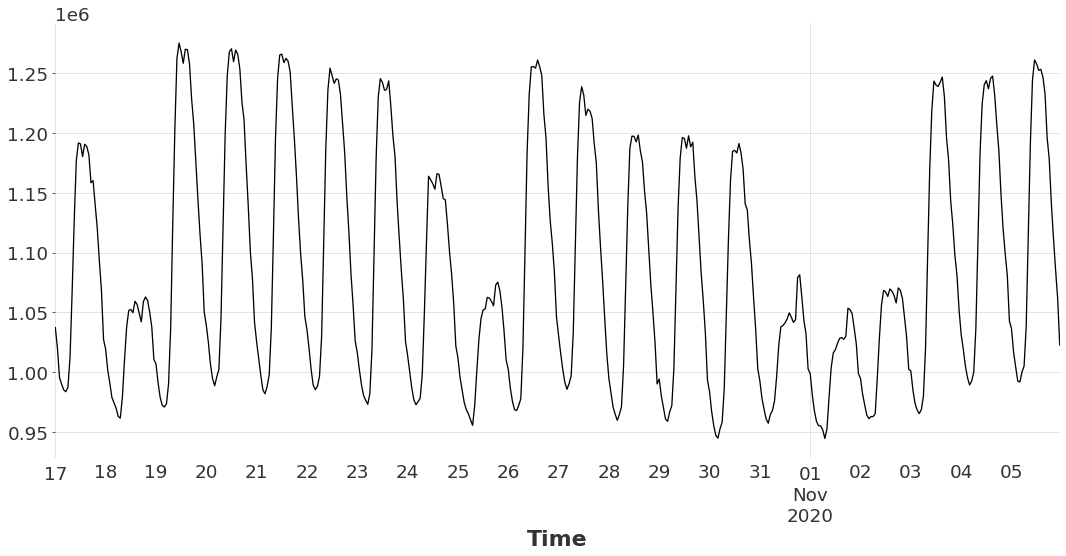

In [10]:
data['Load (kW)'].iloc[-480:].plot()
data

In [11]:
data.loc['2020-10-16 07:00:00']

Load (kW)                  1008339.808
Pressure_kpa                   1012.35
Cloud Cover (%)                 13.625
Humidity (%)                      87.0
Temperature (C)              11.756886
Wind Direction (deg)            55.875
Wind Speed (kmh)               3.16375
day_of_week                          4
time_of_day                          7
is_weekend                       False
rolling_2d              1103539.710067
rolling_3d              1048447.551564
rolling_5d               1103631.41156
rolling_7d              1091667.840922
Name: 2020-10-16 07:00:00, dtype: object

# Create ES model

In [12]:
# !pip install 'statsmodels==0.12.0' --force-reinstall # --upgrade

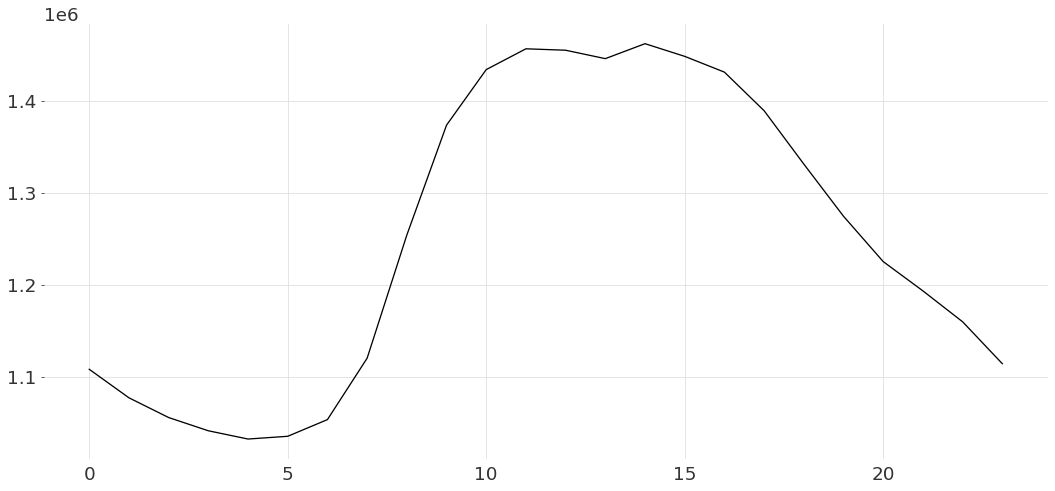

In [40]:
model = ExponentialSmoothing(data['Load (kW)'].values[0:480], seasonal_periods=168, 
                             trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
forecast_seasonal_Holt = model.forecast(24)
plt.plot(forecast_seasonal_Holt)

# Define config

In [41]:
startDay = 28
totalDays = 1300
samplingFreq = 24
minimumTrainDuration = samplingFreq * 13
nlags = 360
significantLags = 30
timeHorizon = 24
slidingWindow = True
slidingWindowDays = 28

# Calculate PACF features

In [42]:
def estimateSignificantLags(ts, nlags = 360, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1   2   3   5   8  12  13  18  19  20  22  23  24  25  26  47  48  49
  50  70  72  74  94  96  98 118 120 122 143 144 146 156 157 158 167 168
 169 170 336 337]


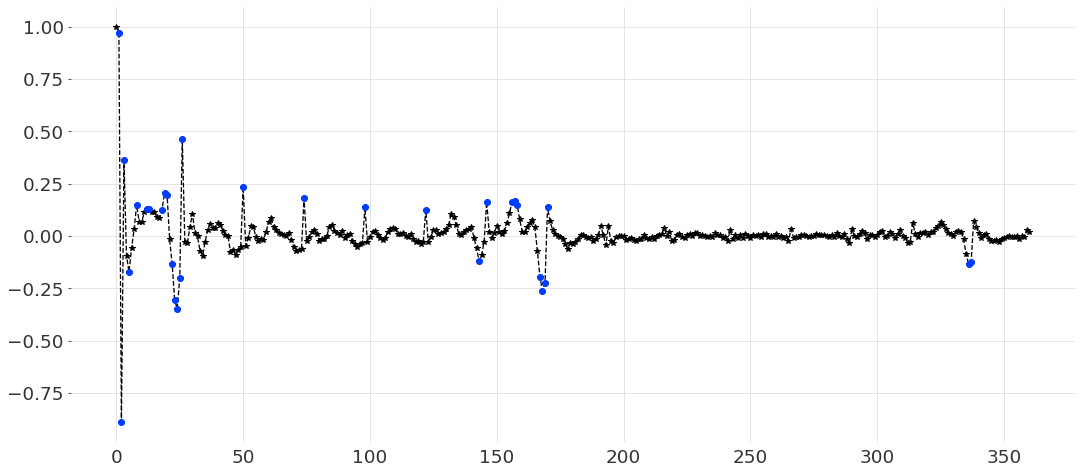

In [43]:
lags = estimateSignificantLags(data['Load (kW)'].dropna(), significantLags = significantLags)
# add lags for certain days
lags = np.unique(np.hstack([lags,[47,48,49,70,72,94,96,118,120,144]]))
print(np.sort(lags))

# Build a forecaster with lagged features

In [44]:
def add_lag_features(df,lags):
    tmp = df.copy()
    for i in lags:
        tmp['lag_'+str(i)] = tmp['Load (kW)'].shift(i)    
    return tmp

In [45]:
lags_df = add_lag_features(data,lags)

## Recursive forecaster

In [46]:
def create_prediction(model_name, start_day='2017-04-07', last_known_day='2018-11-07', 
                      prediction_day='2018-11-08', last_prediction_day='2018-11-09',
                      horizon=48):    
    
    X_train = lags_df.drop(['Load (kW)'], axis=1).loc[start_day:last_known_day]
    y_train = lags_df['Load (kW)'].loc[start_day:last_known_day]
    #print(X_train,y_train)
    model_name.fit(X_train,y_train)

    pred_index = pd.date_range(start=prediction_day, periods=horizon, freq='H')
    pred_df = pd.DataFrame(index=pred_index, columns=['Load (kW)'])
    #print('pred_index',pred_index)
    
    dataCopy = data.copy()
    
    for step in pred_index:
        
        dataCopy = add_lag_features(dataCopy,lags)
        #print(dataCopy.loc[step].name)
        X_pred = pd.DataFrame(dataCopy.drop(['Load (kW)'], axis=1).loc[step]).T
        x_index = dataCopy.loc[step].name
        #print(X_pred)
        pred_df.loc[x_index] = model_name.predict(X_pred)
        
        dataCopy.loc[step, 'Load (kW)'] = pred_df.loc[x_index][0]

    return pred_df

### Creating a df for all models' outputs:

In [17]:
overall_pred = pd.DataFrame(index=data.index, columns=['CB Model'])
overall_pred

,CB Model
Time,
2017-03-18 00:00:00,NaN
2017-03-18 01:00:00,NaN
2017-03-18 02:00:00,NaN
2017-03-18 03:00:00,NaN
2017-03-18 04:00:00,NaN
...,...
2020-11-05 19:00:00,NaN
2020-11-05 20:00:00,NaN
2020-11-05 21:00:00,NaN


In [14]:
n_days = 365

# Create prediction for N days: Catboost

In [ ]:
model = CatBoostRegressor(verbose=False,
                          learning_rate = 0.01, 
                          depth=6,
                          l2_leaf_reg=4,
                          cat_features=['day_of_week','time_of_day','is_weekend']
                     )

overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2017-09-07 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=480+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)

    pred = create_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day, last_prediction_day=prediction_day, 
                             horizon = 41)
    
    prediction = pred.dropna()['Load (kW)'].values[17:41]
    fact = data.loc[pred.dropna().index,'Load (kW)'].values[17:41]

    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[pred.index[17:41], 'CB Model 480d'] = pred['Load (kW)'].iloc[17:41]
    
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['CB Model 480d'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())


prediction_day 2019-01-01 07:00:00
prediction_day 2019-01-02 07:00:00
prediction_day 2019-01-03 07:00:00
prediction_day 2019-01-04 07:00:00
prediction_day 2019-01-05 07:00:00
prediction_day 2019-01-06 07:00:00
prediction_day 2019-01-07 07:00:00
prediction_day 2019-01-08 07:00:00
prediction_day 2019-01-09 07:00:00
prediction_day 2019-01-10 07:00:00
prediction_day 2019-01-11 07:00:00
prediction_day 2019-01-12 07:00:00
prediction_day 2019-01-13 07:00:00
prediction_day 2019-01-14 07:00:00
prediction_day 2019-01-15 07:00:00
prediction_day 2019-01-16 07:00:00
prediction_day 2019-01-17 07:00:00
prediction_day 2019-01-18 07:00:00
prediction_day 2019-01-19 07:00:00
prediction_day 2019-01-20 07:00:00
prediction_day 2019-01-21 07:00:00
prediction_day 2019-01-22 07:00:00
prediction_day 2019-01-23 07:00:00
prediction_day 2019-01-24 07:00:00
prediction_day 2019-01-25 07:00:00
prediction_day 2019-01-26 07:00:00
prediction_day 2019-01-27 07:00:00
prediction_day 2019-01-28 07:00:00
prediction_day 2019-

## Prophet

In [43]:
timeHorizon = 48
startDay = pd.to_datetime('2018-12-01 07:00:00')
offset = 30

for i in range(n_days):

    last_known_day = (startDay + pd.DateOffset(days=offset+i))
    prediction_day = (last_known_day + pd.DateOffset(days=1))
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))
    
    print('prediction_day (offset 1d)',prediction_day)
    
    df = data[['Load (kW)']]
    df['ds'] = df.index
    df['y'] = df['Load (kW)']
    df=df.drop(columns = ['Load (kW)'])
    
#     df=df.loc[startDay:last_known_day]
    df=df.loc[last_known_day-pd.DateOffset(days=offset):last_known_day]
    
#     print(df)
    
    df['temp'] = (data['Temperature (C) '].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['wind_speed'] = (data['Wind Speed (kmh)'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['cloud'] = (data['Cloud Cover (%)'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['wind_direction'] = (data['Wind Direction (deg)'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['pressure'] = (data['Pressure_kpa'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['day_of_week'] = (data['day_of_week'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['time_of_day'] = (data['time_of_day'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    df['is_weekend'] = (data['is_weekend'].loc[last_known_day-pd.DateOffset(days=offset):last_known_day]).values
    
#     m = Prophet(daily_seasonality=40, weekly_seasonality=80, changepoint_prior_scale=0.003, yearly_seasonality=False, seasonality_mode='multiplicative', changepoint_range=.9) #, seasonality_prior_scale=100)
    m = Prophet()
    
    m.add_regressor('temp')
    m.add_regressor('wind_speed')
    m.add_regressor('cloud')
    m.add_regressor('wind_direction')
    m.add_regressor('pressure')
    m.add_regressor('day_of_week')
    m.add_regressor('time_of_day')
    m.add_regressor('is_weekend')
    
    metrics = m.fit(df)
    
    future = m.make_future_dataframe(periods=timeHorizon, freq='1h')
    
    future['temp'] = (data['Temperature (C) '].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['wind_speed'] = (data['Wind Speed (kmh)'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['cloud'] = (data['Cloud Cover (%)'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['wind_direction'] = (data['Wind Direction (deg)'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['pressure'] = (data['Pressure_kpa'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['day_of_week'] = (data['day_of_week'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['time_of_day'] = (data['time_of_day'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    future['is_weekend'] = (data['is_weekend'].loc[last_known_day-pd.DateOffset(days=offset):last_prediction_day]).values
    
    #prophetMatrix[i] = m.predict(future).yhat.iloc[-32:-8]
    overall_pred.loc[future.ds[-32:-8], 'Prophet 30d default'] = m.predict(future).yhat.iloc[-32:-8].values
    

prediction_day (offset 1d) 2019-01-01 07:00:00
prediction_day (offset 1d) 2019-01-02 07:00:00
prediction_day (offset 1d) 2019-01-03 07:00:00
prediction_day (offset 1d) 2019-01-04 07:00:00
prediction_day (offset 1d) 2019-01-05 07:00:00
prediction_day (offset 1d) 2019-01-06 07:00:00
prediction_day (offset 1d) 2019-01-07 07:00:00
prediction_day (offset 1d) 2019-01-08 07:00:00
prediction_day (offset 1d) 2019-01-09 07:00:00
prediction_day (offset 1d) 2019-01-10 07:00:00
prediction_day (offset 1d) 2019-01-11 07:00:00
prediction_day (offset 1d) 2019-01-12 07:00:00
prediction_day (offset 1d) 2019-01-13 07:00:00
prediction_day (offset 1d) 2019-01-14 07:00:00
prediction_day (offset 1d) 2019-01-15 07:00:00
prediction_day (offset 1d) 2019-01-16 07:00:00
prediction_day (offset 1d) 2019-01-17 07:00:00
prediction_day (offset 1d) 2019-01-18 07:00:00
prediction_day (offset 1d) 2019-01-19 07:00:00
prediction_day (offset 1d) 2019-01-20 07:00:00
prediction_day (offset 1d) 2019-01-21 07:00:00
prediction_da

In [46]:
overall_pred.drop(['CB Model'],axis=1).dropna().to_csv('data/district/extra_prophet_runs.csv')

<AxesSubplot:xlabel='Time'>

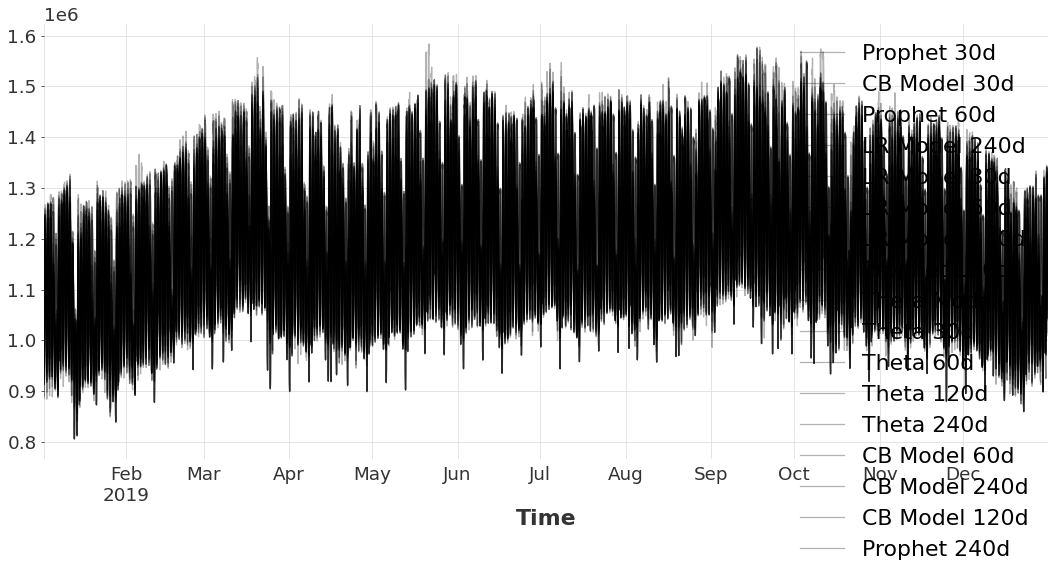

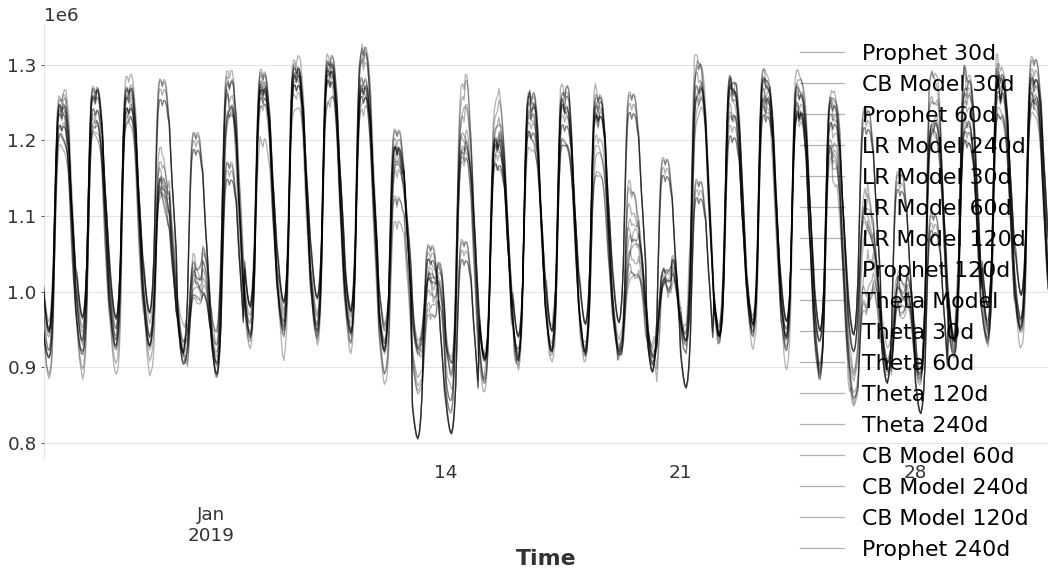

In [94]:
overall_pred.drop(['CB Model'],axis=1).dropna().plot(alpha=0.3, color='black')
# overall_pred.drop(['CB Model'],axis=1).dropna().mean(axis=1).plot(label='Mean')
# data.loc[overall_pred['Prophet 30d'].dropna().index,'Load (kW)'].plot(label='Fact')
plt.legend()

overall_pred.drop(['CB Model'],axis=1).dropna().iloc[0:720].plot(alpha=0.3, color='black')

In [27]:
pred = overall_pred.drop(['CB Model'],axis=1).dropna()
fact = data.loc[overall_pred['Prophet 30d'].dropna().index,'Load (kW)']
print(np.mean(np.abs(pred.values.T - fact.values),axis=1).astype(int))
print(int(np.mean(np.abs(overall_pred.drop(['CB Model'],axis=1).dropna().mean(axis=1) - fact.values))))

ValueError: operands could not be broadcast together with shapes (2,8736) (8784,) 

In [ ]:
future
overall_pred['Prophet_optimized'].dropna().plot()

In [ ]:
# overall_pred['Prophet_optimized'].dropna().to_csv('data/district/prophet.csv')

KeyError: 'Prophet'

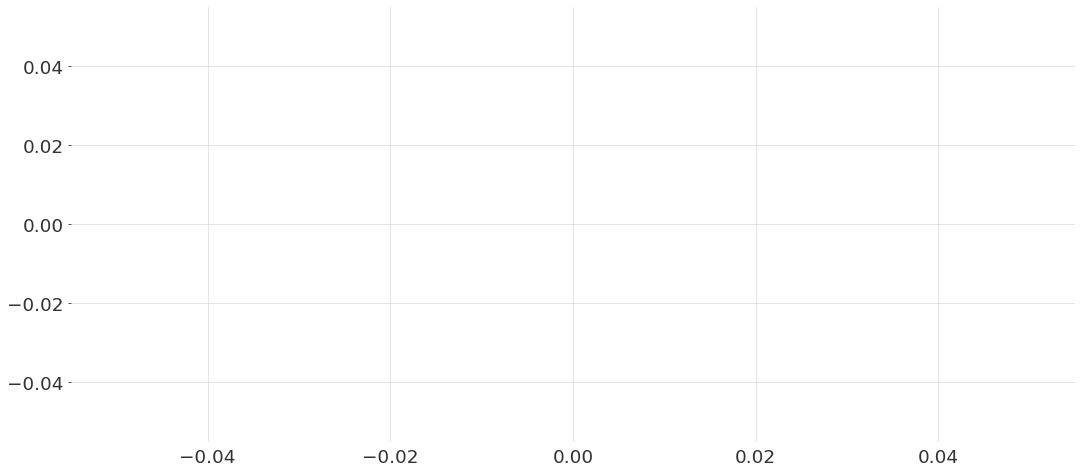

In [96]:
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['Prophet'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

# Create prediction for N days: LR

In [143]:
data = data.drop(['Pressure_kpa','Temperature (C) ','Cloud Cover (%)','Wind Direction (deg)','Wind Speed (kmh)'],axis=1)
lags_df = add_lag_features(data,lags)

prediction_day 2019-01-01 07:00:00
prediction_day 2019-01-02 07:00:00
prediction_day 2019-01-03 07:00:00
prediction_day 2019-01-04 07:00:00
prediction_day 2019-01-05 07:00:00
prediction_day 2019-01-06 07:00:00
prediction_day 2019-01-07 07:00:00
prediction_day 2019-01-08 07:00:00
prediction_day 2019-01-09 07:00:00
prediction_day 2019-01-10 07:00:00
prediction_day 2019-01-11 07:00:00
prediction_day 2019-01-12 07:00:00
prediction_day 2019-01-13 07:00:00
prediction_day 2019-01-14 07:00:00
prediction_day 2019-01-15 07:00:00
prediction_day 2019-01-16 07:00:00
prediction_day 2019-01-17 07:00:00
prediction_day 2019-01-18 07:00:00
prediction_day 2019-01-19 07:00:00
prediction_day 2019-01-20 07:00:00
prediction_day 2019-01-21 07:00:00
prediction_day 2019-01-22 07:00:00
prediction_day 2019-01-23 07:00:00
prediction_day 2019-01-24 07:00:00
prediction_day 2019-01-25 07:00:00
prediction_day 2019-01-26 07:00:00
prediction_day 2019-01-27 07:00:00
prediction_day 2019-01-28 07:00:00
prediction_day 2019-

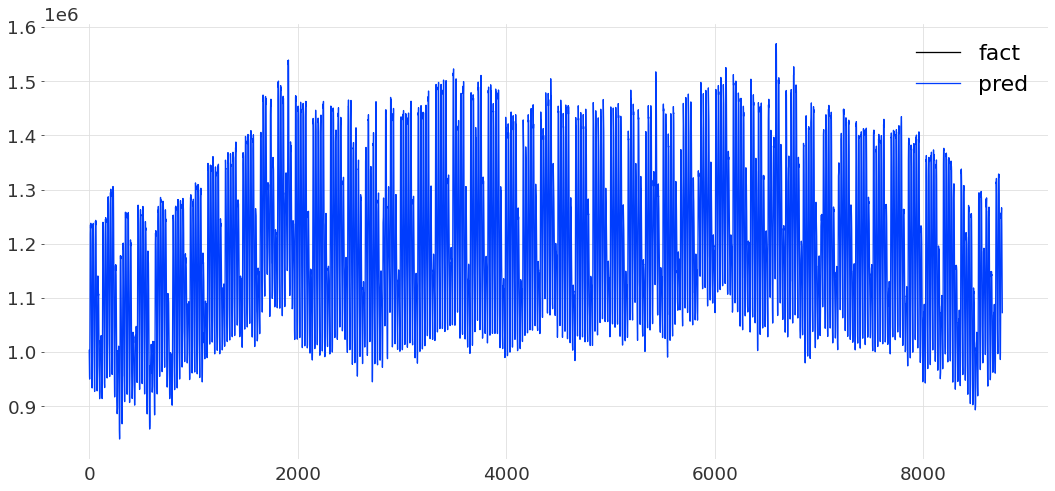

mape 2.7493432736494676


In [51]:
model = linear_model.LinearRegression() # Create a linear model object

overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2018-09-02 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=120+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)

    pred = create_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day, last_prediction_day=prediction_day, 
                             horizon = 41)
    
    prediction = pred.dropna()['Load (kW)'].values[17:41]
    fact = data.loc[pred.dropna().index,'Load (kW)'].values[17:41]

    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[pred.index[17:41], 'LR Model 120d'] = pred['Load (kW)'].iloc[17:41]
    
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred['LR Model 30d'].dropna().values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())


In [153]:
pred = overall_pred.drop(['CB Model', 'Prophet 30d', 'Prophet 60d', 'Prophet 120d', 'Prophet 240d'],axis=1).dropna()
fact = data.loc[overall_pred['LR Model 60d'].dropna().index,'Load (kW)']
print(np.mean(np.abs(pred.values.T - fact.values),axis=1).astype(int))
print(int(np.mean(np.abs(overall_pred.drop(['CB Model', 'Prophet 30d', 'Prophet 60d', 'Prophet 120d', 'Prophet 240d'],axis=1).dropna().mean(axis=1) - fact.values))))


[29183 27389 25910 25668]
25957


<AxesSubplot:xlabel='Time'>

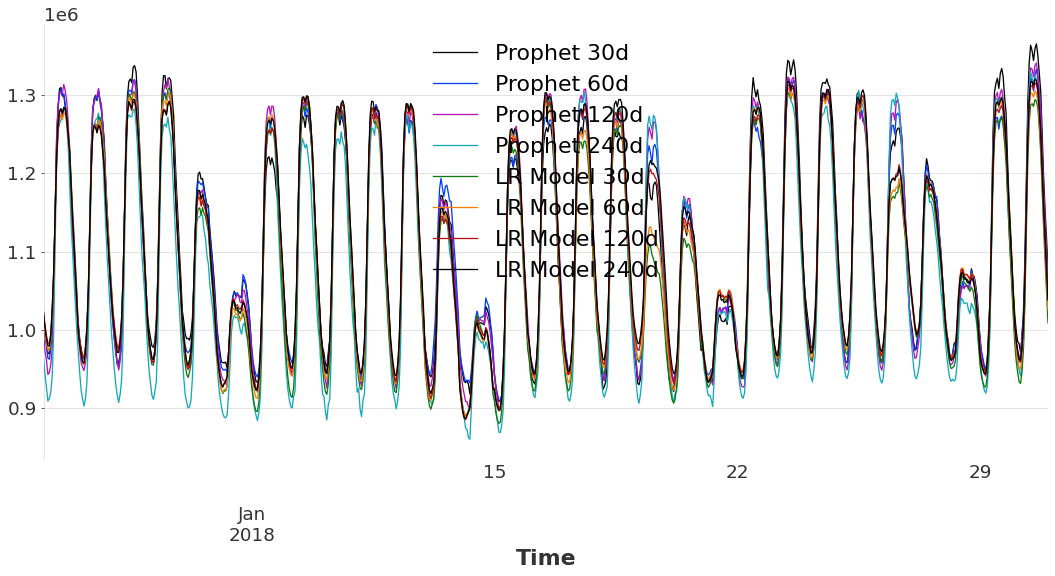

In [154]:
overall_pred.drop(['CB Model'],axis=1).dropna().plot()

# Make theta prediction

In [67]:
def make_theta_prediction(theta_model, start_day, last_known_day, prediction_day, last_prediction_day, horizon):
    
    series = TimeSeries.from_dataframe(pd.DataFrame(data.loc[start_day:last_prediction_day, 'Load (kW)'])) #TimeSeries.from_dataframe(data.reset_index().iloc[start_time-28*24:start_time+nhorizon], 'Time', 'Load (kW)')        
    train, val = series.split_after(pd.Timestamp(last_known_day))
    theta_model.fit(train)
    return theta_model.predict(horizon)


prediction_day 2019-01-01 07:00:00
prediction_day 2019-01-02 07:00:00
prediction_day 2019-01-03 07:00:00
prediction_day 2019-01-04 07:00:00
prediction_day 2019-01-05 07:00:00
prediction_day 2019-01-06 07:00:00
prediction_day 2019-01-07 07:00:00
prediction_day 2019-01-08 07:00:00
prediction_day 2019-01-09 07:00:00
prediction_day 2019-01-10 07:00:00
prediction_day 2019-01-11 07:00:00
prediction_day 2019-01-12 07:00:00
prediction_day 2019-01-13 07:00:00
prediction_day 2019-01-14 07:00:00
prediction_day 2019-01-15 07:00:00
prediction_day 2019-01-16 07:00:00
prediction_day 2019-01-17 07:00:00
prediction_day 2019-01-18 07:00:00
prediction_day 2019-01-19 07:00:00
prediction_day 2019-01-20 07:00:00
prediction_day 2019-01-21 07:00:00
prediction_day 2019-01-22 07:00:00
prediction_day 2019-01-23 07:00:00
prediction_day 2019-01-24 07:00:00
prediction_day 2019-01-25 07:00:00
prediction_day 2019-01-26 07:00:00
prediction_day 2019-01-27 07:00:00
prediction_day 2019-01-28 07:00:00
prediction_day 2019-

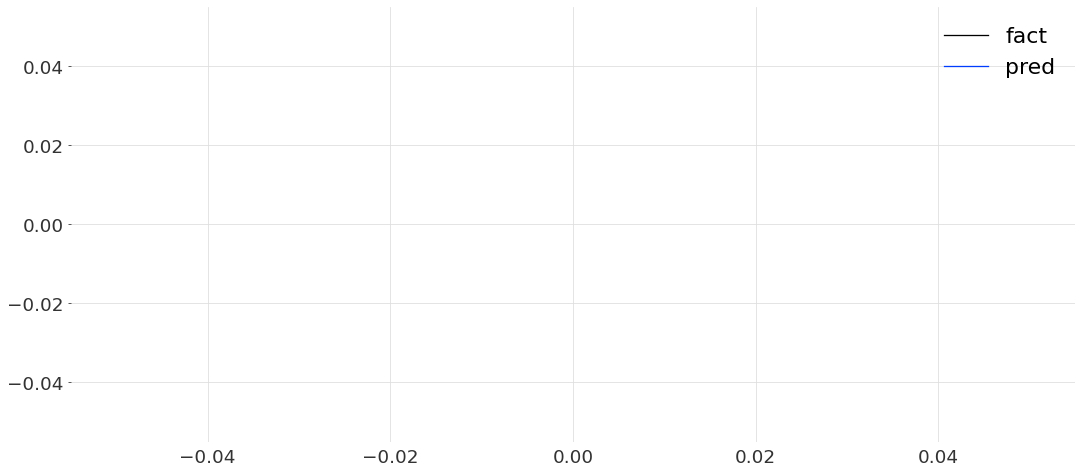

mape 2.7493432736494676


In [74]:
n_horizon = 41
theta_model = Theta(1)
start_day = pd.to_datetime('2018-05-05 07:00:00')

for i in range(n_days):

    last_known_day = (start_day + pd.DateOffset(days=240+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    print('prediction_day',prediction_day)
    
    pred = make_theta_prediction(theta_model,
                                   start_day=start_day, 
                                   last_known_day=last_known_day, 
                                   prediction_day=prediction_day, 
                                   last_prediction_day=last_prediction_day, 
                                   horizon=n_horizon)
        
    overall_pred.loc[pred.time_index()[16:40], 'Theta 240d'] = pred[16:40].values()
    
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['Theta 30d'].values, label='pred')
plt.legend()
plt.show()
print('mape',overall_mape.mean())

In [ ]:
overall_pred['LR Model'].dropna()#.plot()#.values[:-40]

# Comparing models

In [ ]:
prophet_prediction = overall_pred['Prophet'].dropna().values[:-40]
fact = data.loc[overall_pred['Prophet'].dropna().index,'Load (kW)'].values[:-40]
linearNoWeather_prediction = overall_pred['LR Model'].dropna().values[:-40]
cb_prediction = overall_pred['CB Model'].dropna().values[:-40]
theta_prediction = overall_pred['Theta Model'].dropna().values[:-40]
#direct_rf_prediction = overall_pred['Direct RF Model'].dropna().values[:-40]
persistence_7d = data.loc[overall_pred['Prophet'].dropna().index + pd.DateOffset(days=-7),'Load (kW)'].values[:-40]
#persistence_1d = data.loc[overall_pred.dropna().index + pd.DateOffset(days=-1),'Load (kW)'].values

error = prophet_prediction*.225 + cb_prediction*.225 + theta_prediction*.05 + linearNoWeather_prediction*.5 - fact
plt.plot(error)
plt.show()

mape_prophet = 100 * np.mean(np.abs(prophet_prediction - fact)) / np.mean(np.abs(fact))
mape_cb = 100 * np.mean(np.abs(cb_prediction - fact)) / np.mean(np.abs(fact))
mape_lin = 100 * np.mean(np.abs(linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))
mape_theta = 100 * np.mean(np.abs(theta_prediction - fact)) / np.mean(np.abs(fact))
#mape_direct_rf = 100 * np.mean(np.abs(direct_rf_prediction - fact)) / np.mean(np.abs(fact))

mape_comb_1 = 100 * np.mean(np.abs(prophet_prediction*.5 + .5*cb_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_2 = 100 * np.mean(np.abs(prophet_prediction*.5 + .5*linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_3 = 100 * np.mean(np.abs(cb_prediction*.5 + .5*linearNoWeather_prediction - fact)) / np.mean(np.abs(fact))
mape_comb_4 = 100 * np.mean(np.abs(prophet_prediction/5 + cb_prediction/5 + linearNoWeather_prediction*3/5 - fact)) / np.mean(np.abs(fact))
mape_comb_5 = 100 * np.mean(np.abs(prophet_prediction*.25 + cb_prediction*.25 + theta_prediction*.05 + linearNoWeather_prediction*.45 - fact)) / np.mean(np.abs(fact))
mape_comb_5m = 100 * np.mean(np.abs(prophet_prediction*.25 + cb_prediction*.25 + theta_prediction*.25 + linearNoWeather_prediction*.25 - fact)) / np.mean(np.abs(fact))
mape_comb_5p = 100 * np.mean(np.abs(persistence_7d*.1 + prophet_prediction*.2 + cb_prediction*.2 + theta_prediction*.05 + linearNoWeather_prediction*.45 - fact)) / np.mean(np.abs(fact))
mape_persistence_7d = 100 * np.mean(np.abs(persistence_7d - fact)) / np.mean(np.abs(fact))
#mape_persistence_1d = 100 * np.mean(np.abs(persistence_1d - fact)) / np.mean(np.abs(fact))

mape_comb_6 = 100 * np.mean(np.abs(prophet_prediction*.35 + theta_prediction*.05 + linearNoWeather_prediction*.6 - fact)) / np.mean(np.abs(fact))


print('mape Pr:', mape_prophet)
print('mape CB:', mape_cb)
print('mape Linear:', mape_lin)
print('mape Theta:', mape_theta)
#print('mape Direct RF:', mape_direct_rf)

print('mape comb 1:', mape_comb_1)
print('mape comb 2:', mape_comb_2)
print('mape comb 3:', mape_comb_3)
print('mape comb 4 (all - theta):', mape_comb_4)
print('mape comb 5 (all weighted mean):', mape_comb_5)
print('mape comb 5 (all weighted mean + persistence):', mape_comb_5p)
print('mape comb 5 (all mean):', mape_comb_5m)
print('mape comb 6 (no CB):', mape_comb_6)
print('mape pers 7d:', mape_persistence_7d)
# print('mape pers 1d:', mape_persistence_1d)

plt.scatter(prophet_prediction, linearNoWeather_prediction, alpha=0.3)
plt.scatter(fact, linearNoWeather_prediction, alpha=0.3)
plt.scatter(fact, prophet_prediction, alpha=0.3)
plt.show()

plt.plot(sm.tsa.stattools.acf(error,nlags=200), '*--')
plt.show()

# error2D = (error.reshape((nDays,24))).astype(int)
# print(error2D)
# plt.imshow(error2D)
# plt.show()

# plt.boxplot(error2D,1)
# plt.plot(range(1,25), np.mean(error2D,0))
# plt.show()

print(np.corrcoef(prophet_prediction, fact))
print(np.corrcoef(linearNoWeather_prediction.astype('float'), fact))
print(np.corrcoef(cb_prediction.astype('float'), fact))
print(np.corrcoef(theta_prediction, fact))
#print(np.corrcoef(direct_rf_prediction, fact))

In [ ]:
data.loc[overall_pred['Prophet'].dropna().index,'Load (kW)']


In [ ]:
overall_pred['naive_weekly'].loc['2018-01-01 00:00:00':'2019-01-01 00:00:00'] = data['Load (kW)'].loc['2017-12-25 00:00:00':'2018-12-25 00:00:00'].values
overall_pred['fact'] = data.loc[overall_pred['Prophet'].dropna().index,'Load (kW)']
overall_pred['ensemble'] = overall_pred['Prophet']*.25 + overall_pred['CB Model']*.2 + overall_pred['Theta Model']*.05 + overall_pred['LR Model']*.35 + overall_pred['naive_weekly']*.15


In [ ]:
overall_pred.dropna().to_csv('data/district/predictions_2018.csv')

# Direct prediction for residuals

In [ ]:
res_X_train = overall_pred.dropna()
res_X_train['Final_model']= res_X_train['Prophet']*.3+res_X_train['CB Model']*.2+res_X_train['Theta Model']*.05+res_X_train['LR Model']*.45
res_y_train = pd.DataFrame(data.loc[res_X_train.index,'Load (kW)'] - res_X_train['Final_model'], columns=['Error'])

In [ ]:
#res_X_val.shape, res_X_train.shape, res_y_train.shape
res_y_train.to_csv('Errors.csv')

In [ ]:
res_X_train.join(data[['day_of_week','time_of_day','is_weekend']])

In [ ]:
def create_direct_prediction(model_name,start_day='2020-10-15', 
                             last_known_day='2020-12-16',
                             prediction_day='2020-12-17'):    
    
    #start=time.time()
    
    y_train = pd.DataFrame(res_y_train.loc[start_day:last_known_day,'Error'])
    X_train = pd.DataFrame(res_X_train.loc[start_day:last_known_day,'Final_model'])
    
    for i in range(16,40):
        y_train['error_'+str(i)] = y_train['Error'].shift(-i).astype('float64')
        X_train['model_'+str(i)] = X_train['Final_model'].shift(-i).astype('float64')
    
    y_train = y_train.dropna().drop(['Error'], axis=1)
    X_train = X_train.dropna().drop(['Final_model'], axis=1).join(data[['day_of_week','time_of_day','is_weekend']])

    #print('y_train',y_train)
    #print('X_train',X_train)
    
    model_name.fit(X_train,y_train)
    
    step = pd.date_range(start=prediction_day, periods=40, freq='H')

    X_pred = pd.DataFrame(res_X_train.loc[step,'Final_model'])
    for i in range(16,40):
        X_pred['model_'+str(i)] = X_pred['Final_model'].shift(-i).astype('float64')
    X_pred = X_pred.dropna().drop(['Final_model'], axis=1).join(data[['day_of_week','time_of_day','is_weekend']])
    
    prediction = model.predict(X_pred)[0]
    #print(X_pred)
    #print('Predict: ', time.time()-start)
    
    return prediction

#model = MultiOutputRegressor(lgb.LGBMRegressor())

#create_direct_prediction(model)

In [ ]:
overall_pred.dropna()

In [ ]:
params = { 'metric': ['l2', 'auc'],
            'learning_rate': 0.005,
            "num_iterations": 200,
            "n_estimators": 200}

model = MultiOutputRegressor(lgb.LGBMRegressor(**params))
#model = MultiOutputRegressor(linear_model.LinearRegression())


overall_mape = np.zeros(n_days)
start_day = pd.to_datetime('2020-11-30 00:00:00')

for i in range(n_days):
    
    last_known_day = (start_day + pd.DateOffset(days=44+i))#.date()
    prediction_day = (last_known_day + pd.DateOffset(days=1))#.date()
    last_prediction_day = str((prediction_day + pd.DateOffset(days=1)))#.date())
    
    pred = create_direct_prediction(model, start_day=start_day, last_known_day=last_known_day, 
                             prediction_day=prediction_day)
    
    print(prediction_day)
    #prediction = pred.dropna()['Load (kW)'].values[17:41]
#    fact = data.loc[pred.dropna().index,'Load (kW)'].values[17:41]

#    overall_mape[i] = 100 * np.mean(np.abs(prediction - fact)) / np.mean(np.abs(fact))
    
    overall_pred.loc[str(prediction_day.date()), 'Direct Error Model'] = pred
    print(pred)
    
    #print(overall_pred.loc[str(prediction_day.date())])
    
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['Direct Error Model'].values, label='pred')
plt.legend()
plt.show()
#print('mape',overall_mape.mean())

In [ ]:
plt.plot(overall_pred['Direct Error Model'].dropna()[:-16], label='error_pred')
plt.plot(res_y_train.loc[overall_pred['Direct Error Model'].dropna().index,'Error'], label='error_fact')
plt.legend()

In [ ]:
np.corrcoef(overall_pred['Direct Error Model'].dropna().values[:-16].astype('float64'),
     res_y_train.loc[overall_pred['Direct Error Model'].dropna().index,'Error'].dropna().values.astype('float64'))

In [ ]:
plt.plot(data.loc[overall_pred.dropna().index,'Load (kW)'].values, label='fact')
plt.plot(overall_pred.dropna()['CB Model'].values, label='CB Model')
plt.plot(overall_pred.dropna()['Prophet'].values, label='Prophet')
plt.plot(overall_pred.dropna()['LR Model'].values, label='LR Model')
plt.plot(overall_pred.dropna()['Theta Model'].values, label='Theta Model')
#plt.plot(overall_pred.dropna()['Direct RF Model'].values, label='Direct RF Model')
plt.legend()
plt.xlim(800,1300)
plt.show()
print('mape',overall_mape.mean())

In [ ]:
'''overall_pred.dropna().iloc[-192:,:].plot()
overall_pred.dropna().iloc[-192:,:].mean(axis=1).plot(lw=5)
plt.plot(fact,color='red')
plt.show()
# overall_pred = overall_pred.dropna()

plt.plot(prophet_prediction*.25 + cb_prediction*.25 + theta_prediction*.05 + linearNoWeather_prediction*.45,color='black')
plt.plot(prophet_prediction,color='black',alpha=0.3)
plt.plot(cb_prediction,color='black',alpha=0.3)
plt.plot(linearNoWeather_prediction,color='black',alpha=0.3)
plt.plot(theta_prediction,color='black',alpha=0.3)
plt.plot(fact,color='red')
plt.xlim(900,1170)
plt.show()'''

# Make single forecast from ensemble

In [ ]:
prophet_prediction = overall_pred['Prophet'].dropna().iloc[-24:].values
linearNoWeather_prediction = overall_pred['LR Model'].dropna().iloc[-24:].values
cb_prediction = overall_pred['CB Model'].dropna().iloc[-24:].values
theta_prediction = overall_pred['Theta Model'].dropna().iloc[-24:].values

benchmark = data.loc['2021-01-30','Load (kW)'].values

final_prediction = prophet_prediction*.2 + cb_prediction*.15 + theta_prediction*.05 + linearNoWeather_prediction*.3+benchmark*.3

plt.plot(final_prediction,lw=3)
plt.plot(prophet_prediction,label='pr')
plt.plot(linearNoWeather_prediction,label='lin')
plt.plot(cb_prediction,label='cb')
plt.plot(theta_prediction,label='th')
plt.plot(benchmark, label='benchmark')
plt.legend()

np.savetxt('Submitted_Predictions/February-06-Kazmi-Hussain.csv', final_prediction)


In [ ]:
jan19 = pd.read_csv('Submitted_Predictions/February-04-Kazmi-Hussain.csv', header=None)
jan19['fact'] = data.loc['2021-02-04','Load (kW)'].values
jan19 = jan19.dropna()
jan19.plot()

In [ ]:
np.mean(np.abs(jan19[0] - jan19['fact']))# / np.mean(np.abs(jan19['fact']))

In [ ]:
np.mean(np.abs(data['Load (kW)'].loc['2021-01-18':'2021-01-23'].values - data['Load (kW)'].loc['2021-01-11':'2021-01-16'].values))

In [ ]:
fact = data.loc[overall_pred['Prophet'].dropna().index,'Load (kW)'].values[:-40]

In [ ]:
overall_pred.to_csv('overall_pred.csv')

In [ ]:
all_prophet_prediction = overall_pred['Prophet'].dropna()
all_linearNoWeather_prediction = overall_pred['LR Model'].dropna()
all_cb_prediction = overall_pred['CB Model'].dropna()
all_theta_prediction = overall_pred['Theta Model'].dropna()

# all_benchmark = data.loc['2021-01-27','Load (kW)'].values

all_final_prediction = all_prophet_prediction*.3 + all_cb_prediction*.25 + all_theta_prediction*.05 + all_linearNoWeather_prediction*.4


In [ ]:
plt.plot(all_final_prediction.iloc[:-40], label='pred')
plt.plot(data.loc[all_final_prediction.index[:-40], 'Load (kW)'], label='fact')
plt.legend()

In [ ]:
plt.scatter(all_final_prediction.iloc[:-40], data.loc[all_final_prediction.index[:-40], 'Load (kW)'])

np.corrcoef(all_final_prediction.iloc[:-40].values.astype('float'), data.loc[all_final_prediction.index[:-40], 'Load (kW)'].values.astype('float'))

In [ ]:
error = all_final_prediction.iloc[:-40].values.astype('float') - data.loc[all_final_prediction.index[:-40], 'Load (kW)'].values.astype('float')

plt.plot(sm.tsa.stattools.pacf(error, nlags=200),'*--')

In [ ]:
plt.plot(error)

# Define a mixture of experts model

In [ ]:
y = data.loc[overall_pred.dropna().index,'Load (kW)'].dropna()
X = overall_pred.loc[y.index]

X['CB Model'] = X['CB Model'].astype('float')
X['LR Model'] = X['LR Model'].astype('float')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

# X

In [ ]:
mixture_model = lgb.LGBMRegressor()#n_estimators = 2000)
mixture_model = linear_model.LinearRegression()
mixture_model.fit(X_train,y_train)

y_pred = mixture_model.predict(X_test)

# plt.scatter(y_test, X_test['LR Model'])
# plt.scatter(y_test, y_pred)

# print(np.corrcoef(y_test, X_test['LR Model']))
# print(np.corrcoef(y_test, y_pred))

# print(np.mean(np.abs(y_test - X_test['LR Model'])))
# print(np.mean(np.abs(y_test - .05*X_test['Theta Model'] -.45*X_test['LR Model'] - .25*X_test['CB Model'] -.25*X_test['Prophet'])))
# print(np.mean(np.abs(y_test - y_pred)))

# mixture_model.coef_